Testing the effect of decorrelating after larger intervals

In [13]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from node_perturbation.node_perturbation import NPLinear
from node_perturbation.utils import np_train
from decorrelation.utils import decor_train
from decorrelation.decorrelation import Decorrelation, DecorLinear
import matplotlib.pyplot as plt
import argparse

import cProfile
import pstats
from torch.profiler import profile, record_function, ProfilerActivity

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [14]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(1),
        transforms.Normalize((0.5), (0.5)),
        torch.flatten # for input to linear layer
        ])

train_data = MNIST(root='~/Data', train=True, download=True, transform=transform)
train_data = Subset(train_data, np.random.permutation(len(train_data.data))[:1000])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0, drop_last=True)

In [15]:
args = argparse.Namespace(lr=1e-4, decor_lr=1e-0, bias_lr=0.0, kappa=1e-2, epochs=30)

class Model(nn.Sequential):
    def __init__(self, in_features, args):
        super().__init__(DecorLinear(in_features, 100, decor_lr=args.decor_lr, bias_lr=args.bias_lr, kappa=args.kappa))

    def forward(self, x):
        return super().forward(x.view(len(x), -1))
    
lossfun = torch.nn.CrossEntropyLoss().to(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
model = Model(784, args).to(device)

res = decor_train(args, model, lossfun, train_loader, device, decorrelate=False)
Lbp = res[1][-1]

step=2
intervals = np.arange(1, args.epochs, step)
L = torch.zeros(len(intervals))
for i, interval in enumerate(intervals):

    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    model = Model(784, args).to(device)

    res = decor_train(args, model, lossfun, train_loader, device, interval=interval)
    L[i] = res[1][-1]

epoch 0  	time:0.000 s	bp loss: 4.921571	decorrelation loss: 0.000000
epoch 1  	time:0.156 s	bp loss: 4.226156	decorrelation loss: 0.000000
epoch 2  	time:0.145 s	bp loss: 3.092512	decorrelation loss: 0.000000
epoch 3  	time:0.146 s	bp loss: 2.530918	decorrelation loss: 0.000000
epoch 4  	time:0.152 s	bp loss: 2.266700	decorrelation loss: 0.000000
epoch 5  	time:0.151 s	bp loss: 2.120379	decorrelation loss: 0.000000
epoch 6  	time:0.158 s	bp loss: 2.004110	decorrelation loss: 0.000000
epoch 7  	time:0.159 s	bp loss: 1.905755	decorrelation loss: 0.000000
epoch 8  	time:0.158 s	bp loss: 1.823545	decorrelation loss: 0.000000
epoch 9  	time:0.147 s	bp loss: 1.747997	decorrelation loss: 0.000000
epoch 10 	time:0.154 s	bp loss: 1.679484	decorrelation loss: 0.000000
epoch 11 	time:0.151 s	bp loss: 1.605361	decorrelation loss: 0.000000
epoch 12 	time:0.148 s	bp loss: 1.545272	decorrelation loss: 0.000000
epoch 13 	time:0.149 s	bp loss: 1.490555	decorrelation loss: 0.000000
epoch 14 	time:0.148

Text(0, 0.5, 'loss')

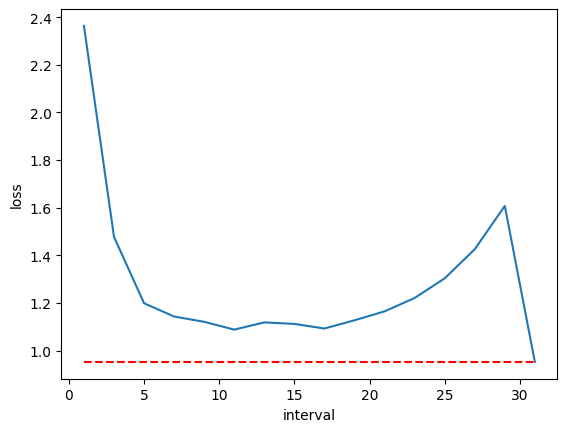

In [16]:
plt.plot(intervals, L)
plt.plot([intervals[0], intervals[-1]], [Lbp, Lbp], 'r--')
plt.xlabel('interval')
plt.ylabel('loss');